### Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! tar -zxvf /content/drive/MyDrive/Uni/DeepRiccy/refcocog.tar.gz
! pip3 install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

local_path = '/content/refcocog/images/'
local_annotations = '/content/refcocog/annotations/'

Streaming output truncated to the last 5000 lines.
./refcocog/images/COCO_train2014_000000433336.jpg
./refcocog/images/COCO_train2014_000000567523.jpg
./refcocog/images/COCO_train2014_000000451554.jpg
./refcocog/images/COCO_train2014_000000439855.jpg
./refcocog/images/COCO_train2014_000000044594.jpg
./refcocog/images/COCO_train2014_000000194276.jpg
./refcocog/images/COCO_train2014_000000272463.jpg
./refcocog/images/COCO_train2014_000000485426.jpg
./refcocog/images/COCO_train2014_000000002774.jpg
./refcocog/images/COCO_train2014_000000346160.jpg
./refcocog/images/COCO_train2014_000000199829.jpg
./refcocog/images/COCO_train2014_000000210057.jpg
./refcocog/images/COCO_train2014_000000544117.jpg
./refcocog/images/COCO_train2014_000000440673.jpg
./refcocog/images/COCO_train2014_000000006151.jpg
./refcocog/images/COCO_train2014_000000514391.jpg
./refcocog/images/COCO_train2014_000000247459.jpg
./refcocog/images/COCO_train2014_000000141257.jpg
./refcocog/images/COCO_train2014_000000378896.jpg

### PC

In [ ]:
local_path = './refcocog/images/' 
local_annotations = './refcocog/annotations/' 

# Baseline

In [2]:
#imports

import json
import pickle
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from pkg_resources import packaging
import clip
import numpy as np

import os
import skimage
import IPython.display

from collections import OrderedDict
import torch

## Dataset

In [43]:
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path_json = path_json
        self.path_pickle = path_pickle
        self.train = train

        #load images and annotations
        with open(self.path_json) as json_data:
            data = json.load(json_data)
            self.img_frame = pd.DataFrame(data['images'])
            self.ann_frame = pd.DataFrame(data['annotations'])
            #self.img_frame = pd.merge(self.img_frame, self.ann_frame, left_on=)


        #load annotations
        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        self.size = self.refs_frame.shape[0]

        #separate each sentence in dataframe
        self.refs_frame = self.refs_frame.explode('sent_ids')
        self.refs_frame = self.refs_frame.explode('sentences')
        self.refs_frame = self.refs_frame.reset_index(drop=True)

        self.dataset = pd.merge(self.refs_frame, self.img_frame, left_on='ann_id', right_on='id')
        self.dataset = pd.merge(self.dataset, self.ann_frame, left_on= "id", right_on="id")
        self.dataset = self.dataset.drop(columns=['category_id_x', 'ann_id', 'license', 'category_id_x', 'iscrowd', 'category_id_y', 'ref_id', 'sent_ids', 'flickr_url', 'coco_url', 'segmentation', 'date_captured', 'sent_ids'])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.dataset.iloc[idx]

    def get_annotation(self, idx):
      return self.ann_frame.iloc[idx]
    
    def get_imgframe(self, idx):
      return self.img_frame.iloc[idx]


In [4]:
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append
    
    return string

In [44]:
#test dataset

dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")

print(dataset[0])


image_id_x                                                419645
split                                                       test
sentences      {'tokens': ['there', 'is', 'red', 'colored', '...
file_name_x               COCO_train2014_000000419645_398406.jpg
file_name_y                      COCO_train2014_000000398406.jpg
height                                                       493
width                                                        500
id                                                        398406
area                                                  90934.0125
image_id_y                                                419645
bbox                              [93.95, 83.29, 504.61, 290.57]
Name: 0, dtype: object


In [6]:
#test clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [45]:
def yolobbox2bbox(x,y,w,h):
    x1, y1 = x+h, y
    x2, y2 = w/2, h/2
    return x, y, x2, y2

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-24 Python-3.9.16 torch-2.0.0+cu118 CPU



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


News reporter with blonde hair and green jacket
[[    0.33012]]
[[     0.2254]]
[[    0.24794]]
[[    0.18892]]
[[    0.21845]]


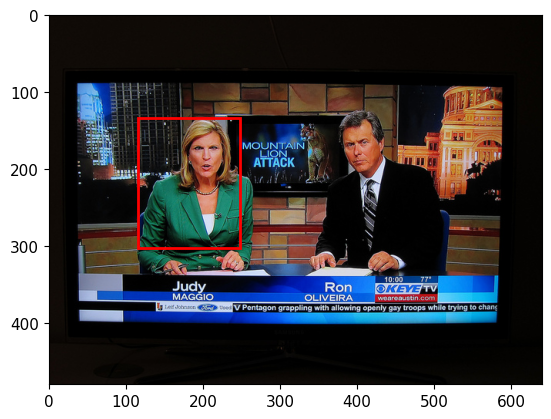

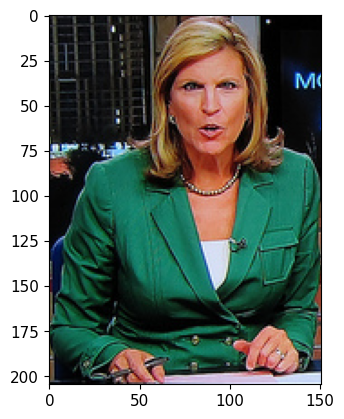

In [46]:
#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#pass image into yolo
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)

input = dataset[55]

image_path = split_string(input["file_name_x"])

yolo_output = yolo(local_path+image_path)

model, preprocess = clip.load("ViT-B/32")
model.eval()
#pass each bounding box segmented image into clip with the sentence

sentence = input["sentences"]["raw"]
print(sentence)

max_similarity = 0
max_image = None
max_bbox = None

original_img = Image.open(local_path+image_path).convert("RGB")    

for i in range(len(yolo_output.xyxy[0])):

    x1 = yolo_output.xyxy[0][i][0].numpy()
    x1 = np.rint(x1)
    y1 = yolo_output.xyxy[0][i][1].numpy()
    y1 = np.rint(y1)
    x2 = yolo_output.xyxy[0][i][2].numpy()
    x2 = np.rint(x2)
    y2 = yolo_output.xyxy[0][i][3].numpy()
    y2 = np.rint(y2)

    img_cropped = original_img.crop((x1, y1, x2, y2))

    img = preprocess(img_cropped).unsqueeze(0)
    image_imput = torch.tensor(img)
    
    text = clip.tokenize([sentence])

    with torch.no_grad():
        image_features = model.encode_image(img).float()
        text_features = model.encode_text(text).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    if similarity > max_similarity:
        max_similarity = similarity
        max_image = img_cropped
        max_bbox = yolo_output.xyxy[0][i]


    print(similarity)


%matplotlib inline
plt.imshow(original_img)
#convert bounding box from yolo format to pil format
bbox = yolobbox2bbox(max_bbox[0], max_bbox[1], max_bbox[2], max_bbox[3])
plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2))

plt.show()

plt.imshow(max_image)
